In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

dp_path = Path("../outputs/dp_results_multitask.csv")
print(dp_path.exists())

df_dp = pd.read_csv(dp_path)
df_dp.head()

True


,target,epsilon,accuracy,macro_f1
0,GENDER,base,0.620397,0.616872
1,GENDER,0.1,0.503440,0.467972
2,GENDER,0.5,0.487252,0.482849
3,GENDER,1.0,0.511938,0.509306
4,GENDER,2.0,0.504654,0.502797


In [2]:
df_dp["is_base"] = df_dp["epsilon"].astype(str) == "base"

# numeric epsilon for plotting (NaN for base)
def parse_eps(e):
    try:
        return float(e)
    except:
        return None

df_dp["epsilon_num"] = df_dp["epsilon"].apply(parse_eps)
df_dp.head()


,target,epsilon,accuracy,macro_f1,is_base,epsilon_num
0,GENDER,base,0.620397,0.616872,True,NaN
1,GENDER,0.1,0.503440,0.467972,False,0.1
2,GENDER,0.5,0.487252,0.482849,False,0.5
3,GENDER,1.0,0.511938,0.509306,False,1.0
4,GENDER,2.0,0.504654,0.502797,False,2.0


In [3]:
summary = df_dp.pivot_table(
    index=["target", "epsilon"],
    values=["accuracy", "macro_f1"]
).reset_index()

summary


,target,epsilon,accuracy,macro_f1
0,ALIVE,0.1,0.761076,0.489911
1,ALIVE,0.5,0.686223,0.467488
2,ALIVE,1.0,0.748129,0.460227
3,ALIVE,10.0,0.853935,0.556942
4,ALIVE,2.0,0.822375,0.518421
5,ALIVE,5.0,0.849282,0.535819
6,ALIVE,base,0.926361,0.691448
7,ETHNICITY,0.1,0.729259,0.490253
8,ETHNICITY,0.5,0.777823,0.491637
9,ETHNICITY,1.0,0.822744,0.514421


In [4]:
out_summary = Path("../outputs/dp_results_summary_table.csv")
summary.to_csv(out_summary, index=False)
out_summary


WindowsPath('../outputs/dp_results_summary_table.csv')

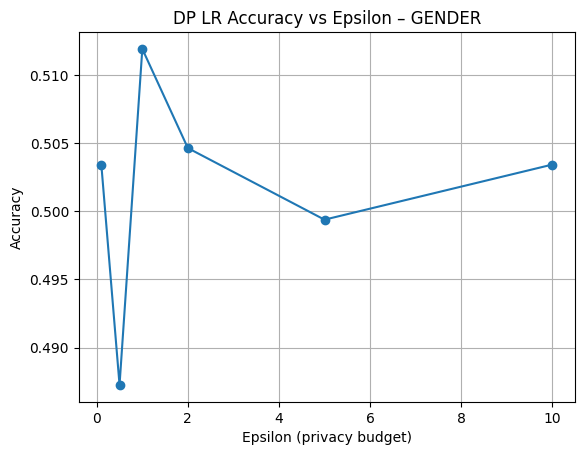

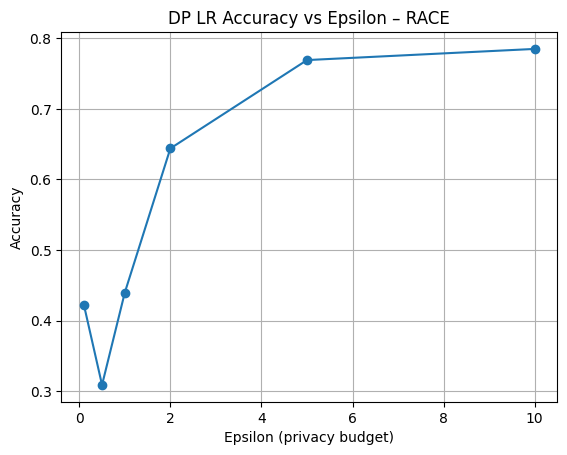

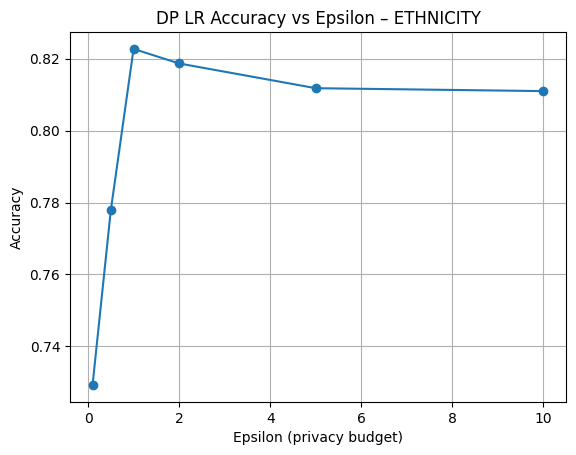

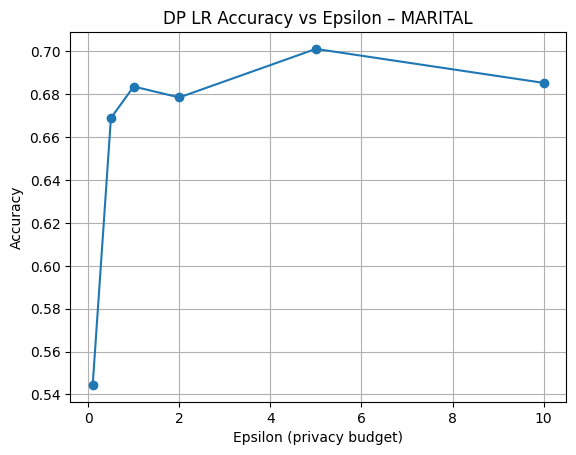

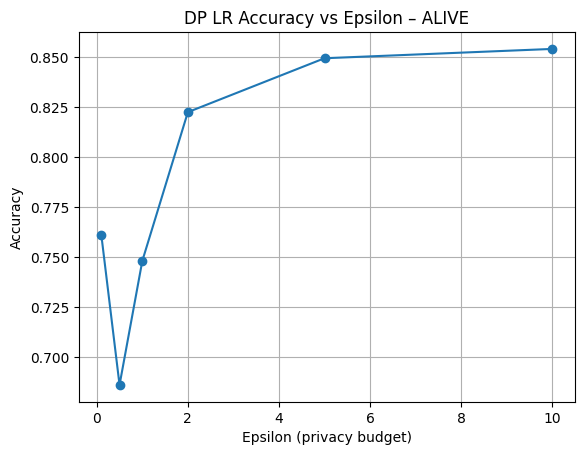

In [5]:
for tgt in df_dp["target"].unique():
    df_t = df_dp[(df_dp["target"] == tgt) & (df_dp["is_base"] == False)].copy()
    if df_t.empty:
        continue

    plt.figure()
    plt.plot(df_t["epsilon_num"], df_t["accuracy"], marker="o")
    plt.title(f"DP LR Accuracy vs Epsilon – {tgt}")
    plt.xlabel("Epsilon (privacy budget)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


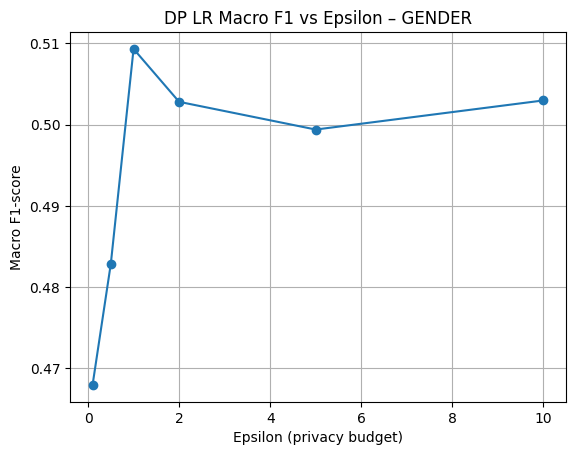

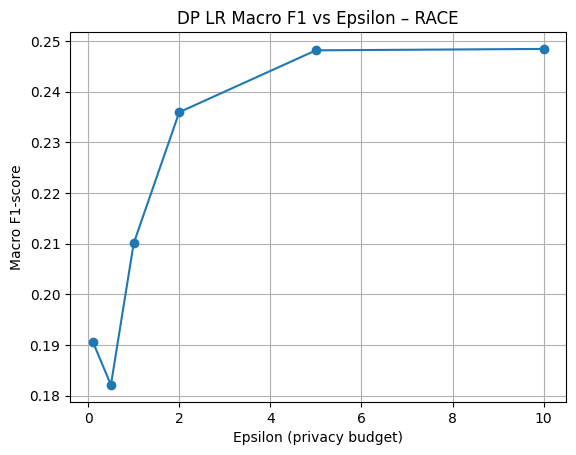

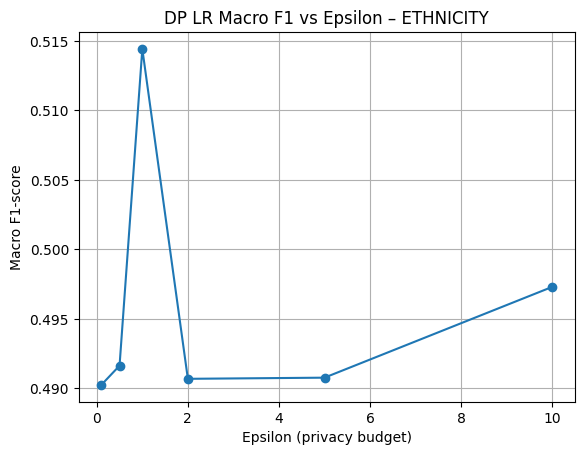

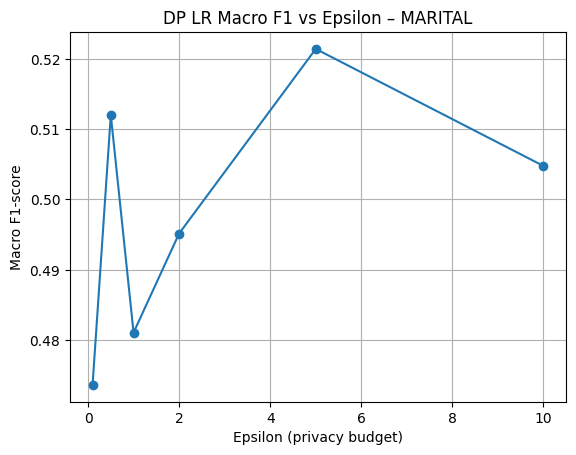

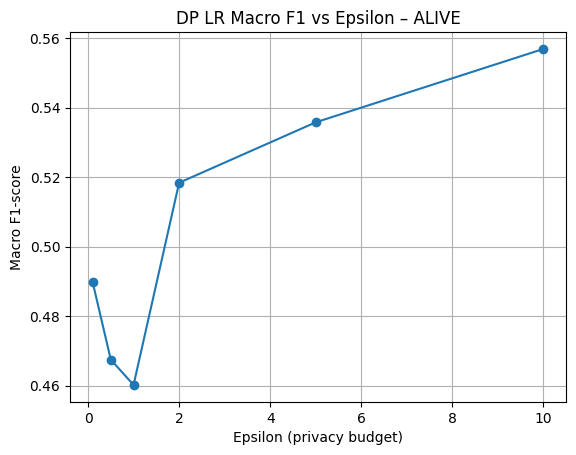

In [6]:
for tgt in df_dp["target"].unique():
    df_t = df_dp[(df_dp["target"] == tgt) & (df_dp["is_base"] == False)].copy()
    if df_t.empty:
        continue

    plt.figure()
    plt.plot(df_t["epsilon_num"], df_t["macro_f1"], marker="o")
    plt.title(f"DP LR Macro F1 vs Epsilon – {tgt}")
    plt.xlabel("Epsilon (privacy budget)")
    plt.ylabel("Macro F1-score")
    plt.grid(True)
    plt.show()


In [7]:
import json
from sklearn_crfsuite import CRF, metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

silver_path = Path("../interim/silver_ner_training.jsonl")
print(silver_path.exists())

sequences = []
with silver_path.open("r") as f:
    for line in f:
        item = json.loads(line)
        sequences.append((item["tokens"], item["labels"]))

len(sequences)


True


2000

In [8]:
import re

def word_shape(token):
    shape = []
    for ch in token:
        if ch.isupper():
            shape.append("X")
        elif ch.islower():
            shape.append("x")
        elif ch.isdigit():
            shape.append("d")
        else:
            shape.append(ch)
    return "".join(shape)

def token_features(tokens, i):
    token = tokens[i]
    feats = {
        "bias": 1.0,
        "word.lower()": token.lower(),
        "word.isupper()": token.isupper(),
        "word.istitle()": token.istitle(),
        "word.isdigit()": token.isdigit(),
        "word.shape": word_shape(token),
        "suffix3": token[-3:],
        "prefix1": token[:1],
    }

    if i > 0:
        prev = tokens[i-1]
        feats.update({
            "-1:word.lower()": prev.lower(),
            "-1:word.istitle()": prev.istitle(),
            "-1:word.isupper()": prev.isupper(),
        })
    else:
        feats["BOS"] = True

    if i < len(tokens) - 1:
        nxt = tokens[i+1]
        feats.update({
            "+1:word.lower()": nxt.lower(),
            "+1:word.istitle()": nxt.istitle(),
            "+1:word.isupper()": nxt.isupper(),
        })
    else:
        feats["EOS"] = True

    return feats

def sent2features(tokens):
    return [token_features(tokens, i) for i in range(len(tokens))]


In [9]:
# sequence data for CRF
X_seq = []
y_seq = []
for tokens, labels in sequences:
    if len(tokens) != len(labels):
        continue
    X_seq.append(sent2features(tokens))
    y_seq.append(labels)

# flatten for SVM/RF/XGB
X_flat_feats = []
y_flat = []
for tokens, labels in sequences:
    if len(tokens) != len(labels):
        continue
    feats_list = sent2features(tokens)
    for f, lab in zip(feats_list, labels):
        X_flat_feats.append(f)
        y_flat.append(lab)

len(X_seq), len(X_flat_feats)


(2000, 97397)

In [10]:
# sequence split
n_total = len(X_seq)
n_train = int(0.8 * n_total)
X_train_seq = X_seq[:n_train]
y_train_seq = y_seq[:n_train]
X_test_seq = X_seq[n_train:]
y_test_seq = y_seq[n_train:]

# flat split
vec = DictVectorizer(sparse=True)
X_flat = vec.fit_transform(X_flat_feats)

X_train_flat, X_test_flat, y_train_flat, y_test_flat = train_test_split(
    X_flat, y_flat, test_size=0.2, random_state=42, stratify=y_flat
)

X_train_flat.shape, X_test_flat.shape


((77917, 27929), (19480, 27929))

In [11]:
model_scores = []

# 1) CRF
crf = CRF(
    algorithm="lbfgs",
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)
crf.fit(X_train_seq, y_train_seq)
y_pred_seq = crf.predict(X_test_seq)

labels_crf = list(crf.classes_)
labels_crf = [l for l in labels_crf if l != "O"]

crf_report = metrics.flat_classification_report(
    y_test_seq, y_pred_seq, labels=labels_crf, digits=3, output_dict=True
)
crf_macro_f1 = crf_report["macro avg"]["f1-score"]

model_scores.append({"model": "CRF", "macro_f1": crf_macro_f1})
print("CRF macro F1:", crf_macro_f1)

# 2) SVM
svm_clf = LinearSVC()
svm_clf.fit(X_train_flat, y_train_flat)
y_pred_svm = svm_clf.predict(X_test_flat)

svm_report = classification_report(
    y_test_flat, y_pred_svm, digits=3, output_dict=True
)
svm_macro_f1 = svm_report["macro avg"]["f1-score"]
model_scores.append({"model": "SVM", "macro_f1": svm_macro_f1})
print("SVM macro F1:", svm_macro_f1)

# 3) Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200, n_jobs=-1, random_state=42
)
rf_clf.fit(X_train_flat, y_train_flat)
y_pred_rf = rf_clf.predict(X_test_flat)

rf_report = classification_report(
    y_test_flat, y_pred_rf, digits=3, output_dict=True
)
rf_macro_f1 = rf_report["macro avg"]["f1-score"]
model_scores.append({"model": "RandomForest", "macro_f1": rf_macro_f1})
print("RF macro F1:", rf_macro_f1)

# 4) XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_flat)
y_test_enc = le.transform(y_test_flat)

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    objective="multi:softmax",
    num_class=len(le.classes_)
)
xgb_clf.fit(X_train_flat, y_train_enc)
y_pred_xgb_enc = xgb_clf.predict(X_test_flat)
y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)

xgb_report = classification_report(
    y_test_flat, y_pred_xgb, digits=3, output_dict=True
)
xgb_macro_f1 = xgb_report["macro avg"]["f1-score"]
model_scores.append({"model": "XGBoost", "macro_f1": xgb_macro_f1})
print("XGB macro F1:", xgb_macro_f1)

model_scores


CRF macro F1: 0.992202640731804


d:\conda_envs\rithi_env\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM macro F1: 0.8500080045276448


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


RF macro F1: 0.7843745946247932


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


XGB macro F1: 0.8550753341159975


d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\conda_envs\rithi_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


[{'model': 'CRF', 'macro_f1': 0.992202640731804},
 {'model': 'SVM', 'macro_f1': 0.8500080045276448},
 {'model': 'RandomForest', 'macro_f1': 0.7843745946247932},
 {'model': 'XGBoost', 'macro_f1': 0.8550753341159975}]

In [12]:
df_models = pd.DataFrame(model_scores)
df_models


,model,macro_f1
0,CRF,0.992203
1,SVM,0.850008
2,RandomForest,0.784375
3,XGBoost,0.855075


In [13]:
df_models.to_csv("../outputs/phi_model_macro_f1.csv", index=False)


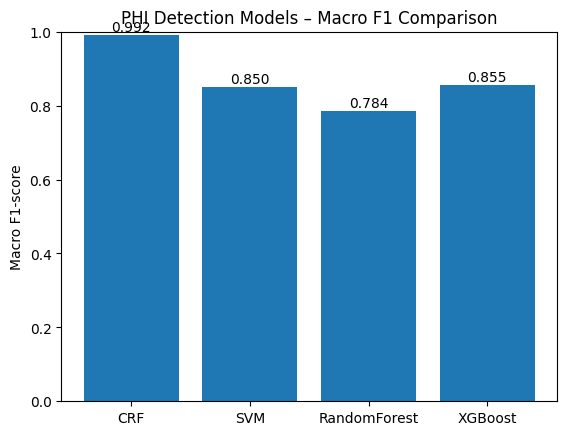

In [14]:
plt.figure()
plt.bar(df_models["model"], df_models["macro_f1"])
plt.ylabel("Macro F1-score")
plt.title("PHI Detection Models – Macro F1 Comparison")
plt.ylim(0, 1)
for i, v in enumerate(df_models["macro_f1"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()


In [15]:
df_deid = pd.read_csv("../processed/patient_notes_deidentified.csv")

df_deid[["note", "note_redacted"]].head(5)


,note,note_redacted
0,Patient Jacinto644 Kris249. They were born on ...,Patient Jacinto644 Kris249. They were born on ...
1,Patient Alva958 Krajcik437. They were born on ...,Patient Alva958 Krajcik437. They were born on ...
2,Patient Jayson808 Fadel536. They were born on ...,Patient Jayson808 Fadel536. They were born on ...
3,Patient Jimmie93 Harris789. They were born on ...,Patient Jimmie93 Harris789. They were born on ...
4,Patient Gregorio366 Auer97. They were born on ...,Patient Gregorio366 Auer97. They were born on ...


In [16]:
examples = df_deid.sample(5, random_state=42)[["note", "note_redacted"]]
examples.to_csv("../outputs/deidentification_examples.csv", index=False)
examples

,note,note_redacted
4106,Patient Armando772 Miller503. They were born o...,Patient Armando772 Miller503. They were born o...
10834,Patient Harold594 Kunze215. They were born on ...,Patient Harold594 Kunze215. They were born on ...
6913,Patient Zenobia558 Batz141. They were born on ...,Patient Zenobia558 Batz141. They were born on ...
1661,Patient Jerrod232 Altenwerth646. They were bor...,Patient Jerrod232 Altenwerth646. They were bor...
24071,Patient Kyoko885 Stroman228. They were born on...,Patient Kyoko885 Stroman228. They were born on...
